Based on:

@book{leborgne2022fraud,

title={Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook},

author={Le Borgne, Yann-A{\"e}l and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca},

url={https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook},

year={2022},

publisher={Universit{\'e} Libre de Bruxelles}

}

Covered subchapters:
* 6.4 Ensemble learning

In [1]:
import datetime
import sklearn
import time
import pickle
import imblearn
import pandas as pd

In [3]:
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   351k      0 --:--:-- --:--:-- --:--:--  352k


In [4]:
DIR_INPUT = '../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


n_folds = 4

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

Load  files
CPU times: total: 391 ms
Wall time: 386 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [5]:
classifier = sklearn.ensemble.BaggingClassifier()

parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__bootstrap':[True],
              'clf__n_estimators':[100],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_bagging = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

performances_df_baseline_bagging=performances_df

In [7]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)
(train_df, test_df)=scaleData(train_df,test_df,input_features)

classifier = sklearn.ensemble.BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0),
                                                n_estimators=100, random_state=0, n_jobs=-1)
classifier.fit(train_df[input_features], train_df[output_feature])
pickle.dump(classifier, open('models/ML_imbalance_not_included/bagging_dt_maxdepth20_nestimators100_model.sav', 'wb'))

In [6]:
classifier = sklearn.ensemble.RandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

performances_df_baseline_rf=performances_df

In [8]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50],
              'clf__learning_rate':[0.3],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_xgboost = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

performances_df_baseline_xgboost=performances_df

In [9]:
summary_performances_baseline_bagging=get_summary_performances(performances_df_baseline_bagging, parameter_column_name="Parameters summary")
summary_performances_baseline_rf=get_summary_performances(performances_df_baseline_rf, parameter_column_name="Parameters summary")
summary_performances_baseline_xgboost=get_summary_performances(performances_df_baseline_xgboost, parameter_column_name="Parameters summary")
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_baseline_xgboost.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Baseline RF', 'Baseline XGBoost']
summary_test_performances

,Baseline Bagging,Baseline RF,Baseline XGBoost
AUC ROC,0.856+/-0.02,0.87+/-0.02,0.872+/-0.01
Average precision,0.678+/-0.01,0.678+/-0.01,0.687+/-0.01
Card Precision@100,0.293+/-0.01,0.299+/-0.01,0.302+/-0.01


##### Balanced bagging

In [10]:
classifier = imblearn.ensemble.BalancedBaggingClassifier()

parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.02, 0.05, 0.1, 0.5, 1], 
              'clf__bootstrap':[True],
              'clf__sampler':[imblearn.under_sampling.RandomUnderSampler()],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_balanced_bagging = time.time()-start_time

In [12]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_balanced_bagging=performances_df

In [13]:
summary_performances_balanced_bagging = get_summary_performances(performances_df_balanced_bagging, parameter_column_name="Parameters summary")
summary_performances_balanced_bagging

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.5,0.02,0.1
Validation performance,0.88+/-0.0,0.704+/-0.01,0.289+/-0.02
Test performance,0.879+/-0.01,0.68+/-0.01,0.305+/-0.01
Optimal parameter(s),0.5,0.02,0.5
Optimal test performance,0.879+/-0.01,0.68+/-0.01,0.305+/-0.01


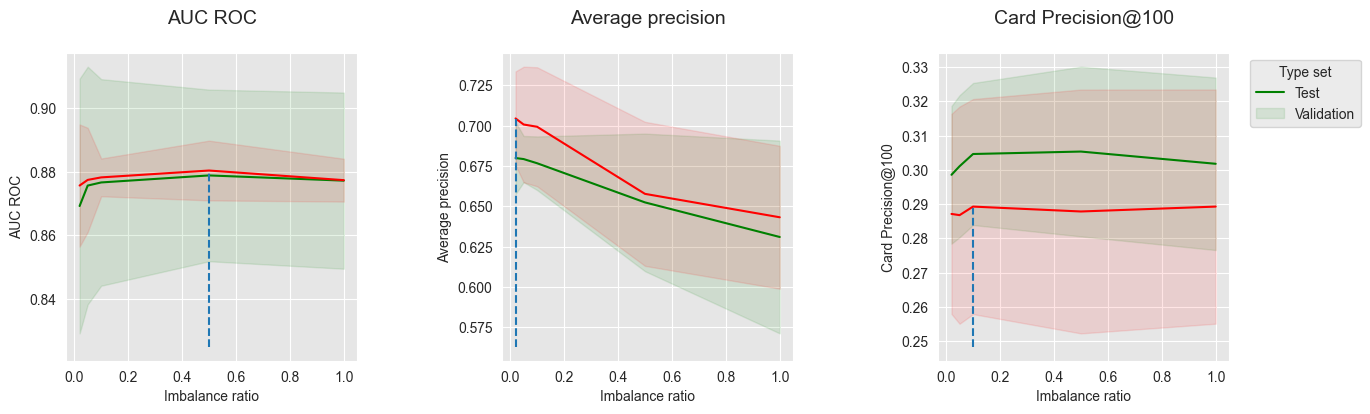

In [14]:
get_performances_plots(performances_df_balanced_bagging, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_balanced_bagging)

In [15]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)
(train_df, test_df)=scaleData(train_df,test_df,input_features)

classifier = imblearn.ensemble.BalancedBaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0),
                                                n_estimators=100, sampling_strategy=0.1, sampler=imblearn.under_sampling.RandomUnderSampler(),
                                                random_state=0, n_jobs=-1)
classifier.fit(train_df[input_features], train_df[output_feature])
pickle.dump(classifier, open('models/ML_imbalance_included/bagging_dt_maxdepth20_nestimators100_randundersampl0dot1_model.sav', 'wb'))

##### Balanced Random Forest

In [16]:
classifier = imblearn.ensemble.BalancedRandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_rf_balanced = time.time()-start_time

In [17]:
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_balanced_rf=performances_df

In [18]:
summary_performances_balanced_rf=get_summary_performances(performances_df=performances_df_balanced_rf, parameter_column_name="Parameters summary")
summary_performances_balanced_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.05,0.01,0.05
Validation performance,0.882+/-0.0,0.695+/-0.02,0.291+/-0.02
Test performance,0.872+/-0.02,0.677+/-0.01,0.302+/-0.01
Optimal parameter(s),0.5,0.01,0.01
Optimal test performance,0.876+/-0.01,0.677+/-0.01,0.304+/-0.01


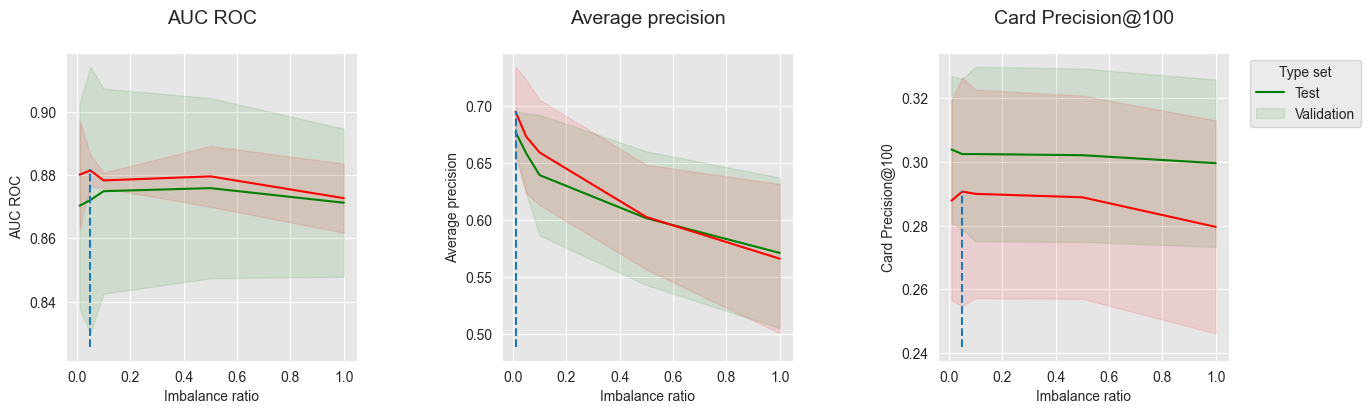

In [19]:
get_performances_plots(performances_df_balanced_rf, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_balanced_rf)

In [26]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)
(train_df, test_df)=scaleData(train_df,test_df,input_features)

classifier = imblearn.ensemble.BalancedRandomForestClassifier(max_depth=20, n_estimators=100, sampling_strategy=0.05, random_state=0, n_jobs=-1)
classifier.fit(train_df[input_features], train_df[output_feature])
pickle.dump(classifier, open('models/ML_imbalance_included/rf_maxdepth20_nestimators100_randundersampl0dot05_model.sav', 'wb'))

##### Weighted XGBoost

In [20]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50],
              'clf__learning_rate':[0.3],
              'clf__scale_pos_weight':[1,5,10,50,100], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_xgboost = time.time()-start_time

In [21]:
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__scale_pos_weight'] for i in range(len(parameters_dict))]

performances_df_weighted_xgboost=performances_df

In [22]:
summary_performances_weighted_xgboost=get_summary_performances(performances_df=performances_df_weighted_xgboost, parameter_column_name="Parameters summary")
summary_performances_weighted_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,1,1,5
Validation performance,0.883+/-0.01,0.708+/-0.02,0.289+/-0.01
Test performance,0.872+/-0.01,0.687+/-0.01,0.3+/-0.01
Optimal parameter(s),1,1,1
Optimal test performance,0.872+/-0.01,0.687+/-0.01,0.302+/-0.01


For all metrics, increasing the class weight leads to a decrease in performances on the test set

##### Summary

In [23]:
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_balanced_bagging.iloc[2,:],
                                       summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_balanced_rf.iloc[2,:],
                                       summary_performances_baseline_xgboost.iloc[2,:],
                                       summary_performances_weighted_xgboost.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Balanced Bagging', 
                                   'Baseline RF', 'Balanced RF', 
                                   'Baseline XGBoost', 'Weighted XGBoost']

In [24]:
summary_test_performances

,Baseline Bagging,Balanced Bagging,Baseline RF,Balanced RF,Baseline XGBoost,Weighted XGBoost
AUC ROC,0.856+/-0.02,0.879+/-0.01,0.87+/-0.02,0.872+/-0.02,0.872+/-0.01,0.872+/-0.01
Average precision,0.678+/-0.01,0.68+/-0.01,0.678+/-0.01,0.677+/-0.01,0.687+/-0.01,0.687+/-0.01
Card Precision@100,0.293+/-0.01,0.305+/-0.01,0.299+/-0.01,0.302+/-0.01,0.302+/-0.01,0.3+/-0.01
